В данном ноутбуке создается и обучается регрессионная модель на pytorch, которая аппроксимирует
значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.

В качестве обучающей выборки используется 20000 точек, сгенерированных случайным образом.

Полученный датасет делится на train/test/ val в отношениях 70%/15%/15%, соответственно.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Генерация данных для искомой функции

In [2]:
def target_function(x, y):
    return torch.sin(x + 2 * y) * torch.exp(-(2 * x + y) ** 2)

# Обучаем на gpu, инференс на cpu
cpu = torch.device("cpu")
gpu = torch.device("cuda:0")

# Параметры
N_POINTS = 20000
RANGE = 10.0
SPLIT_RATIOS = [0.70, 0.15, 0.15]
BATCH_SIZE = 64
EPOCHS = 200

# Генерация точек
np.random.seed(42)  # для репродуктивности
x_np = np.random.uniform(-RANGE, RANGE, N_POINTS)
y_np = np.random.uniform(-RANGE, RANGE, N_POINTS)

# Преобразуем из numpy в pytorch тензоры
x_tensor = torch.from_numpy(x_np).float().unsqueeze(1)  # (N, 1)
y_tensor = torch.from_numpy(y_np).float().unsqueeze(1)  # (N, 1)

# Объединяем точки x и y в единый тензор
X = torch.cat((x_tensor, y_tensor), dim=1).to(gpu)

# Вычистяем таргет
Y = target_function(x_tensor, y_tensor).to(gpu)

# Создаем датасет
dataset = TensorDataset(X, Y)

Делим данные на train/test/validation

In [3]:
# Размеры выборок
n_train = int(SPLIT_RATIOS[0] * N_POINTS)
n_test = int(SPLIT_RATIOS[1] * N_POINTS)
n_val = N_POINTS - n_train - n_test

# Рандомно делим датасет с поощью random_split
train_data, test_data, val_data = random_split(
    dataset, [n_train, n_test, n_val], generator=torch.Generator().manual_seed(42)
)

print(f"Dataset sizes: Train={len(train_data)}, Test={len(test_data)}, Val={len(val_data)}")

# Создаем DataLoader'ы для каждой выборки
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

Dataset sizes: Train=14000, Test=3000, Val=3000


Объявляем и инициализируем модель регрессии

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Входной слой: вход 2 (x, y), выход 64
            nn.Linear(2, 64),
            # Активатор LeakyReLU
            nn.LeakyReLU(),
            # Линейный слой, вход 64, выход 128
            nn.Linear(64, 128),
            # Активатор LeakyReLU
            nn.LeakyReLU(),
            # Линейный слой, вход 128, выход 64
            nn.Linear(128, 64),
            # Активатор LeakyReLU
            nn.LeakyReLU(),
            # Выходной слой: вход 64, выход 1 (f(x, y))
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


# Инициализация модели
model = Model().to(gpu)
# Инициализация функции потерь MSE
criterion = nn.MSELoss()
# Инициализация оптимизатора Adam с learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

Цикл обучения

In [5]:
# Обучение 1й эпохи
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


# Прямой проход
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)


# Метрики качества для визуализации
train_losses = []
val_losses = []

print("\nStarting Training...")
for epoch in range(EPOCHS):
    # Обучение
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)

    # Валидация
    val_loss = evaluate(model, val_loader, criterion)

    # Метрики качества для визуализации
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print("Training finished.")


Starting Training...
Epoch [20/200], Train Loss: 0.006354, Val Loss: 0.007647
Epoch [40/200], Train Loss: 0.000891, Val Loss: 0.001429
Epoch [60/200], Train Loss: 0.000556, Val Loss: 0.000476
Epoch [80/200], Train Loss: 0.000655, Val Loss: 0.000838
Epoch [100/200], Train Loss: 0.000450, Val Loss: 0.000365
Epoch [120/200], Train Loss: 0.001699, Val Loss: 0.007100
Epoch [140/200], Train Loss: 0.000177, Val Loss: 0.000350
Epoch [160/200], Train Loss: 0.000838, Val Loss: 0.000411
Epoch [180/200], Train Loss: 0.000193, Val Loss: 0.000361
Epoch [200/200], Train Loss: 0.000179, Val Loss: 0.000327
Training finished.


Финальный прогон на тестовых данных

In [6]:
test_loss = evaluate(model, test_loader, criterion)
print(f"\nFinal Test MSE Loss: {test_loss:.6f}")
print(f"Final Test Root Mean Squared Error (RMSE): {np.sqrt(test_loss):.6f}")


Final Test MSE Loss: 0.000194
Final Test Root Mean Squared Error (RMSE): 0.013937


Визуализация

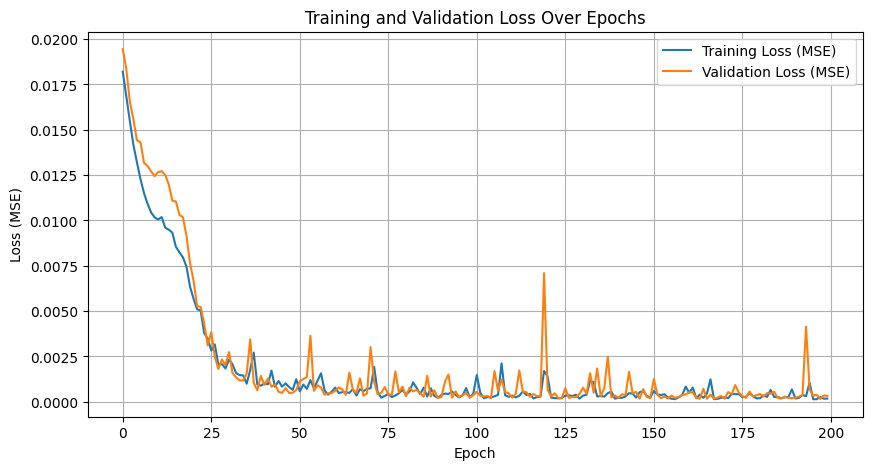

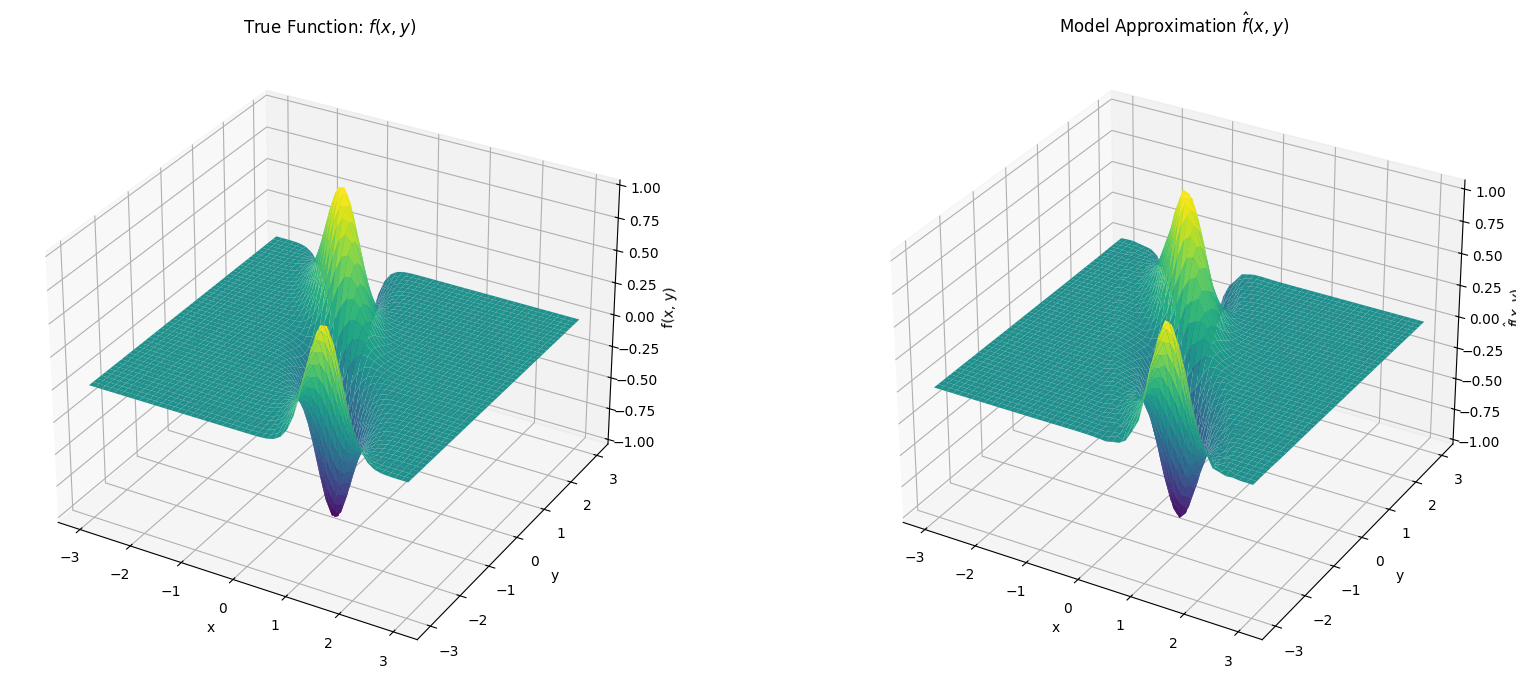

In [7]:
# Визуализация процесса обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss (MSE)')
plt.plot(val_losses, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

GRID_POINTS = 50
x_grid = torch.linspace(-3, 3, GRID_POINTS)
y_grid = torch.linspace(-3, 3, GRID_POINTS)
X_mesh, Y_mesh = torch.meshgrid(x_grid, y_grid, indexing='ij')

# Таргеты
Z_true = target_function(X_mesh.unsqueeze(-1), Y_mesh.unsqueeze(-1)).squeeze()

# Предсказание модели
X_flat = torch.cat((X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)), dim=1)
model.to(cpu).eval()
with torch.no_grad():
    Z_pred_flat = model(X_flat)
Z_pred = Z_pred_flat.reshape(GRID_POINTS, GRID_POINTS)

fig = plt.figure(figsize=(18, 7))

# График исходной функции
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_mesh.numpy(), Y_mesh.numpy(), Z_true.numpy(), cmap='viridis')
ax1.set_title('True Function: $f(x, y)$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')

# График предсказанной функции
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_mesh.numpy(), Y_mesh.numpy(), Z_pred.numpy(), cmap='viridis')
ax2.set_title('Model Approximation $\\hat{f}(x, y)$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('$\\hat{f}(x, y)$')

plt.tight_layout()
plt.show()